In [1]:
# Standard library imports
import sys

# Contributed library imports
import geopandas as gpd
import numpy as np

# Our imports
from multiview_mapping_toolkit.meshes import TexturedPhotogrammetryMesh
from multiview_mapping_toolkit.utils.prediction_metrics import compute_and_show_cf
from multiview_mapping_toolkit.utils.geospatial import get_overlap_vector

sys.path.append("../..")
from constants import (
    get_IDs_to_labels,
    get_numpy_export_cf_filename,
    get_predicted_vector_labels_filename,
    get_predicted_polygons_labels_filename,
    get_mesh_filename,
    get_camera_filename,
    get_DTM_filename,
    get_numpy_export_faces_texture_filename,
    get_mesh_transform_filename,
    LABELS_COLUMN,
    LABELS_FILENAME,
    BUFFER_RADIUS_METERS,
    HEIGHT_ABOVE_GROUND_THRESH,
    GROUND_WEIGHT_POLYGON_LABELING,
)

# Set constants
You should be able to define most of the behavior from these constants

In [2]:
PREDICTION_SITE = "chips"
TRAINING_SITES = sorted(["delta", "lassic", "valley"])

In [3]:
IDs_TO_LABELS = get_IDs_to_labels()

In [4]:
NUMPY_EXPORT_CONFUSION_MATRIX_FILE = get_numpy_export_cf_filename(
    PREDICTION_SITE, training_sites=TRAINING_SITES, is_ortho=False
)

# Ground truth classes

Loading transform to EPSG:4326
Loading mesh
Reading the mesh
Selecting an ROI from mesh
Standardizing ROI
Dissolving ROI
Setting CRS and buffering ROI
Dissolving buffered ROI
Extracting verts for dataframe
Checking intersection of verts with ROI
Extracting points from pyvista mesh
Extraction surface from subset mesh
Extracting faces from mesh
Loading texture
Could not read texture as a scalar from the pyvista mesh
Could not read texture as a numpy file


Sampling values from raster /ofo-share/scratch-david/organized-str-disp-MVMT-experiments/per_site_processing/chips/02_photogrammetry/exports/dtms/chips.tif: 100%|██████████| 520337/520337 [00:21<00:00, 24585.11it/s]


This method will be deprecated in favor of get_IDs_to_labels since it doesn't handle non-sequential indices


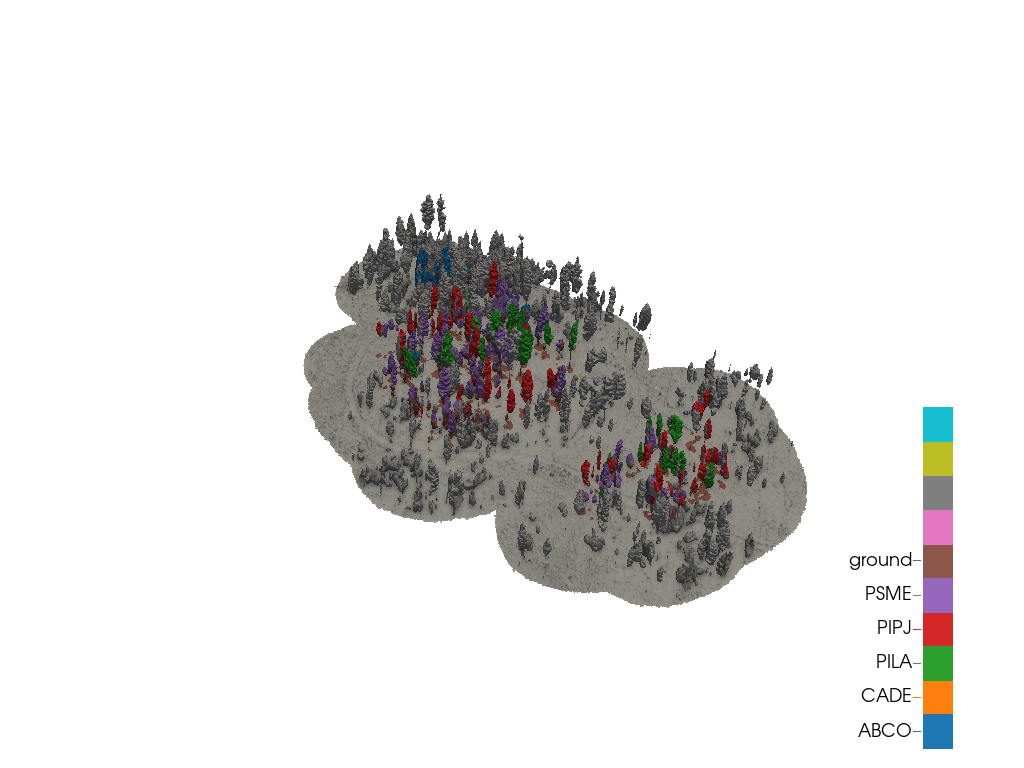

In [5]:
MESH_FILENAME = get_mesh_filename(PREDICTION_SITE)
CAMERAS_FILENAME = get_camera_filename(PREDICTION_SITE)
DTM_FILE = get_DTM_filename(PREDICTION_SITE)
TRANSFORM_FILENAME = get_mesh_transform_filename(PREDICTION_SITE)

mesh = TexturedPhotogrammetryMesh(
    MESH_FILENAME,
    transform_filename=TRANSFORM_FILENAME,
    texture=LABELS_FILENAME,
    texture_column_name=LABELS_COLUMN,
    ROI=LABELS_FILENAME,
    ROI_buffer_meters=BUFFER_RADIUS_METERS,
)
mesh.label_ground_class(
    height_above_ground_threshold=HEIGHT_ABOVE_GROUND_THRESH,
    DTM_file=DTM_FILE,
    set_mesh_texture=True,
)
mesh.vis(force_xvfb=True)

# Per-polygon labeling using the mesh from above for convenience

In [6]:
predicted_face_classes_filename = get_numpy_export_faces_texture_filename(
    prediction_site=PREDICTION_SITE, training_sites=TRAINING_SITES
)
# TODO consider masking no prediction faces
predicted_face_classes = np.argmax(np.load(predicted_face_classes_filename), axis=1)

ground_mask = mesh.get_height_above_ground(
    DTM_file=DTM_FILE,
    threshold=HEIGHT_ABOVE_GROUND_THRESH,
)
ground_mask_faces = mesh.vert_to_face_texture(ground_mask)

# Ground points get a weighting of 0.01, others get 1
weighting = 1 - (1 - GROUND_WEIGHT_POLYGON_LABELING) * ground_mask_faces.astype(float)

polygons = gpd.read_file(LABELS_FILENAME).query("fire==@PREDICTION_SITE")

predicted_filename = get_predicted_polygons_labels_filename(
    PREDICTION_SITE, TRAINING_SITES, False
)

print(f"Weighting shape {weighting.shape}")
predicted_class_labels = mesh.label_polygons(
    predicted_face_classes, polygons, face_weighting=weighting
)
polygons["predicted_labels"] = predicted_class_labels
polygons.to_file(predicted_filename)

gt_list = polygons[LABELS_COLUMN]
cf, classes, accuracy = compute_and_show_cf(
    pred_labels=predicted_class_labels,
    gt_labels=gt_list,
    labels=list(IDs_TO_LABELS.values()),
)
np.save(NUMPY_EXPORT_CONFUSION_MATRIX_FILE, cf)
print(f"Accuracy: {accuracy}")

Sampling values from raster /ofo-share/scratch-david/organized-str-disp-MVMT-experiments/per_site_processing/chips/02_photogrammetry/exports/dtms/chips.tif: 100%|██████████| 520337/520337 [00:21<00:00, 23731.69it/s]


Computing faces in working CRS


/ofo-share/repos-david/conda/envs/MVMT-dev2/lib/python3.9/site-packages/geopandas/geodataframe.py:1543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
Converting faces to polygons: 100%|██████████| 1035882/1035882 [00:16<00:00, 64113.35it/s]

Creating dataframe of faces


ValueError: All arrays must be of the same length

# Predicted classes

Loading transform to EPSG:4326


INFO:mesh_140578946926864:Loading transform to EPSG:4326


Loading mesh


INFO:mesh_140578946926864:Loading mesh


Reading the mesh


INFO:mesh_140578946926864:Reading the mesh


Selecting an ROI from mesh


INFO:mesh_140578946926864:Selecting an ROI from mesh


Standardizing ROI


INFO:mesh_140578946926864:Standardizing ROI


Dissolving ROI


INFO:mesh_140578946926864:Dissolving ROI


Setting CRS and buffering ROI


INFO:mesh_140578946926864:Setting CRS and buffering ROI


Dissolving buffered ROI


INFO:mesh_140578946926864:Dissolving buffered ROI


Extracting verts for dataframe


INFO:mesh_140578946926864:Extracting verts for dataframe


Checking intersection of verts with ROI


INFO:mesh_140578946926864:Checking intersection of verts with ROI


Extracting points from pyvista mesh


INFO:mesh_140578946926864:Extracting points from pyvista mesh


Extraction surface from subset mesh


INFO:mesh_140578946926864:Extraction surface from subset mesh


Extracting faces from mesh


INFO:mesh_140578946926864:Extracting faces from mesh


Loading texture


INFO:mesh_140578946926864:Loading texture


This method will be deprecated in favor of get_IDs_to_labels since it doesn't handle non-sequential indices


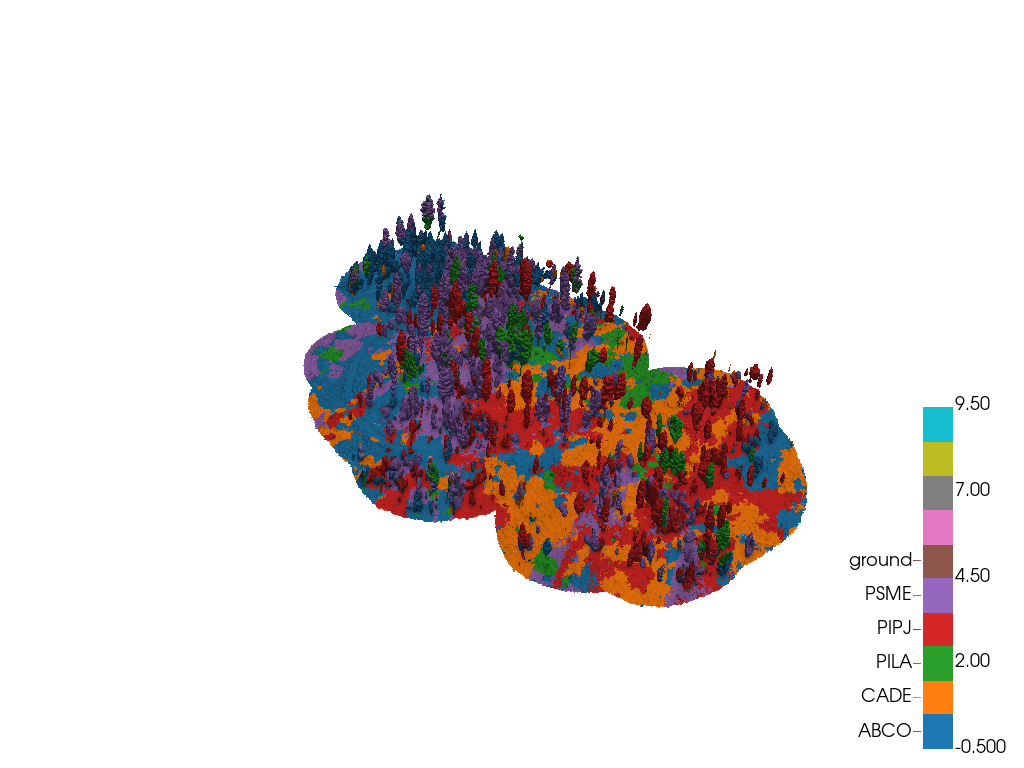

In [ ]:
MESH_TRANSFORM = get_mesh_transform_filename(PREDICTION_SITE)
NUMPY_EXPORT_FACES_TEXTURE_FILE = get_numpy_export_faces_texture_filename(
    PREDICTION_SITE, training_sites=TRAINING_SITES
)
predicted_texture = np.argmax(np.load(NUMPY_EXPORT_FACES_TEXTURE_FILE), axis=1)

mesh = TexturedPhotogrammetryMesh(
    MESH_FILENAME,
    transform_filename=MESH_TRANSFORM,
    texture=predicted_texture,
    IDs_to_labels=IDs_TO_LABELS,
    ROI=LABELS_FILENAME,
    ROI_buffer_meters=BUFFER_RADIUS_METERS,
)
mesh.vis(force_xvfb=True)

# Colored mesh

Loading transform to EPSG:4326


INFO:mesh_140578935380528:Loading transform to EPSG:4326


Loading mesh


INFO:mesh_140578935380528:Loading mesh


Reading the mesh


INFO:mesh_140578935380528:Reading the mesh


Selecting an ROI from mesh


INFO:mesh_140578935380528:Selecting an ROI from mesh


Standardizing ROI


INFO:mesh_140578935380528:Standardizing ROI


Dissolving ROI


INFO:mesh_140578935380528:Dissolving ROI


Setting CRS and buffering ROI


INFO:mesh_140578935380528:Setting CRS and buffering ROI


Dissolving buffered ROI


INFO:mesh_140578935380528:Dissolving buffered ROI


Extracting verts for dataframe


INFO:mesh_140578935380528:Extracting verts for dataframe


Checking intersection of verts with ROI


INFO:mesh_140578935380528:Checking intersection of verts with ROI


Extracting points from pyvista mesh


INFO:mesh_140578935380528:Extracting points from pyvista mesh


Extraction surface from subset mesh


INFO:mesh_140578935380528:Extraction surface from subset mesh


Extracting faces from mesh


INFO:mesh_140578935380528:Extracting faces from mesh


Loading texture


INFO:mesh_140578935380528:Loading texture


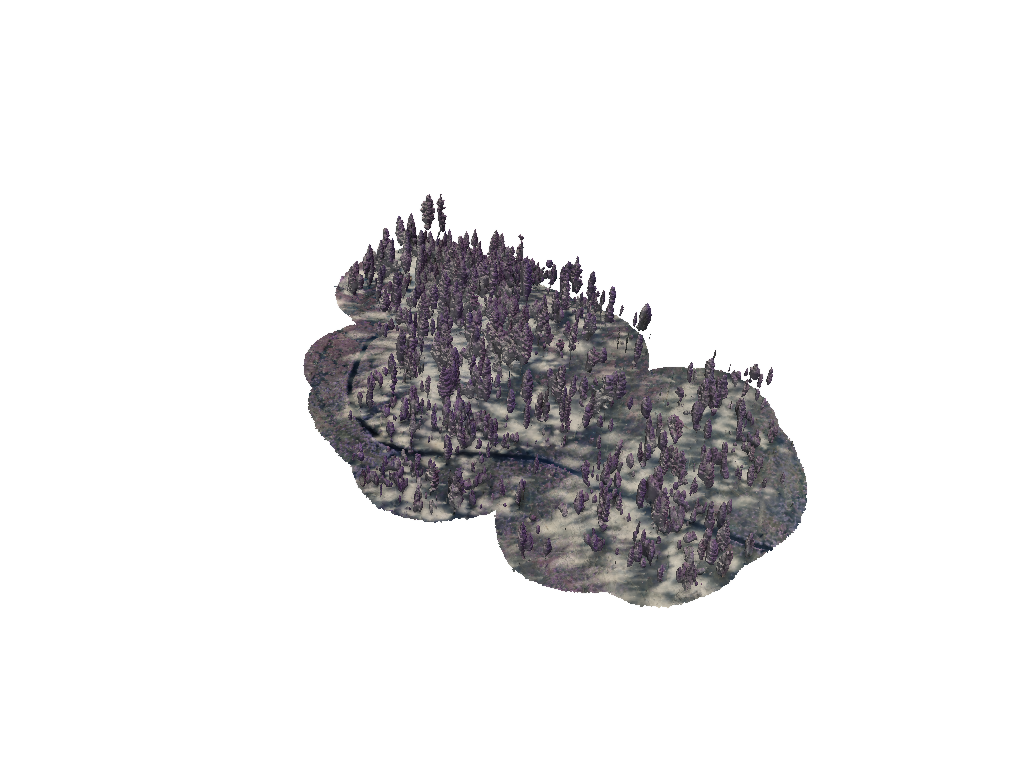

In [ ]:
mesh = TexturedPhotogrammetryMesh(
    MESH_FILENAME,
    transform_filename=CAMERAS_FILENAME,
    ROI=LABELS_FILENAME,
    ROI_buffer_meters=BUFFER_RADIUS_METERS,
)
mesh.vis(force_xvfb=True)